* This notebook is a modified version of https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
* Only the image inputs are used.

# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as  imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchvision import transforms

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os
import math
import warnings

tqdm.pandas()

# Config

In [6]:
class Config():
    IMAGE_SIZE0 = 512
    IMAGE_SIZE = {
        'efficientnetv2_rw_t.ra2_in1k': 224,
        'resnet50.a1_in1k': 224,
        'vgg19.tv_in1k': 224
    }
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    TARGET_COLUMNS_TEST = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
    N_TARGETS = len(TARGET_COLUMNS)
    # Dataset
    RECOMPUTE_DATAFRAMES = False
    BATCH_SIZE = 96
    BATCH_SIZE_VAL = 128
    N_VAL_SAMPLES0 = 4096
    # Training
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 8
    TRAIN_MODEL = True
    # Others
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    SEED = 42
    EPS = 1e-6
    EPS_CUDA = torch.tensor([EPS]).to('cuda')
        
CONFIG = Config()

# Train DataFrame

In [7]:
if CONFIG.RECOMPUTE_DATAFRAMES:
    train0 = pd.read_csv('/kaggle/input/planttraits2024/train.csv')

    # Add File Path
    train0['file_path'] = train0['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')

    # Reaed Raw Image JPEG Bytes
    train0['jpeg_bytes'] = train0['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    
    # Save for Future Use
    train0.to_pickle('train.pkl')
else:
    train0 = pd.read_pickle('/kaggle/input/planttraits2024-eda-training-pub-dataset/train.pkl')
    
# Assign Medians
CONFIG.TARGET_MEDIANS = train0[CONFIG.TARGET_COLUMNS].median(axis=0).values

In [8]:
# Split train in train/val
# train0 = train0.head(1000)
train, val = train_test_split(train0, test_size=0.2, shuffle=True, random_state=CONFIG.SEED)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Test DataFrame

In [9]:
if CONFIG.RECOMPUTE_DATAFRAMES:
    test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')

    # Add File Path
    test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')

    # Reaed Raw Image JPEG Bytes
    test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())

    # Save for Future Use
    test.to_pickle('test.pkl')
else:
    test = pd.read_pickle('/kaggle/input/my-dataset/test (1).pkl')

In [10]:
# Feature Columns
FEATURE_COLUMNS = test.columns.values[1:-2]
CONFIG.N_FEATURES = len(FEATURE_COLUMNS)
print(f'N_FEATURES: {CONFIG.N_FEATURES}')

N_FEATURES: 163


In [11]:
# Minimum/Maximum Based On Train 0.1% and 99.9%
CONFIG.V_MIN = train[CONFIG.TARGET_COLUMNS].quantile(0.001)
CONFIG.V_MAX = train[CONFIG.TARGET_COLUMNS].quantile(0.999)

# Labels

In [12]:
# Labels Meta Data
target_name_meta = pd.read_csv('/kaggle/input/planttraits2024/target_name_meta.tsv', delimiter='\t')
target_name_meta['trait_ID'] = target_name_meta['trait_ID'] + '_mean'
target_name_meta = target_name_meta.set_index('trait_ID').squeeze().to_dict()

display(pd.Series(target_name_meta).to_frame())

,0
X4_mean,Stem specific density (SSD) or wood density (s...
X11_mean,Leaf area per leaf dry mass (specific leaf are...
X18_mean,Plant height
X26_mean,Seed dry mass
X50_mean,Leaf nitrogen (N) content per leaf area
X3112_mean,"Leaf area (in case of compound leaves: leaf, u..."


In [13]:
# Percentiles of features to use
percentiles = [
    0.001, 0.01,0.05,0.10,0.25,
    0.50,
    0.75,0.90,0.95,0.99, 0.999,
]
labels_describe_df = pd.DataFrame()
for target in CONFIG.TARGET_COLUMNS:
    labels_describe_df = pd.concat((
        labels_describe_df,
        train[target].describe(percentiles=percentiles).round(3)
    ), axis=1)
    
# Transpose DataFrame
labels_describe_df = labels_describe_df.T
    
# Minimum/Maximum Values
labels_describe_df.insert(4, 'v_min', CONFIG.V_MIN)
labels_describe_df.insert(16, 'v_max', CONFIG.V_MAX)
    
display(labels_describe_df)

,count,mean,std,min,v_min,0.1%,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,v_max,max
X4_mean,44391.0,0.522,0.175,-2.431,-0.460978,-0.461,0.226,0.304,0.338,0.411,0.509,0.623,0.724,0.796,0.918,1.425,1.424552,4.475000e+00
X11_mean,44391.0,126.669,12379.491,0.000,0.730477,0.730,3.089,4.928,6.461,10.651,15.129,19.696,25.323,30.958,51.096,618.885,618.884844,1.504254e+06
X18_mean,44391.0,12347.008,1826052.961,0.000,0.005098,0.005,0.041,0.102,0.162,0.310,0.720,3.594,11.264,16.884,28.523,199.684,199.684349,2.720494e+08
X50_mean,44391.0,12.825,1313.435,0.000,0.060027,0.060,0.485,0.773,0.924,1.173,1.478,1.926,2.494,3.032,4.486,38.820,38.820458,1.597599e+05
X26_mean,44391.0,3104.024,221045.964,0.000,0.000980,0.001,0.011,0.047,0.118,0.555,2.524,15.133,79.011,219.671,1390.946,9612.628,9612.627530,3.106555e+07
X3112_mean,44391.0,10112.274,720052.287,0.000,1.132863,1.133,11.291,43.261,89.842,255.300,729.224,2157.196,4829.203,8175.283,24730.883,233333.321,233333.321450,8.653530e+07


# Plot outliers

# Filter Outliers

In [14]:
# Mask to exclude values outside of 0.1% - 99.9% range
def get_mask(df):
    lower = []
    higher = []
    mask = np.empty(shape=df[CONFIG.TARGET_COLUMNS].shape, dtype=bool)
    # Fill mask based on minimum/maximum values of sample submission
    for idx, (t, v_min, v_max) in enumerate(zip(CONFIG.TARGET_COLUMNS, CONFIG.V_MIN, CONFIG.V_MAX)):
        labels = df[t].values
        mask[:,idx] = ((labels > v_min) & (labels < v_max))
    return mask.min(axis=1)

# Masks
CONFIG.MASK_TRAIN = get_mask(train)
CONFIG.MASK_VAL = get_mask(val)
# Masked DataFrames
train_mask = train[CONFIG.MASK_TRAIN].reset_index(drop=True)
val_mask = val[CONFIG.MASK_VAL].reset_index(drop=True)
# Add Number Of Steps
CONFIG.N_TRAIN_SAMPLES = len(train_mask)
CONFIG.N_VAL_SAMPLES = len(val_mask)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_VAL_STEPS_PER_EPOCH = math.ceil(CONFIG.N_VAL_SAMPLES / CONFIG.BATCH_SIZE_VAL)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

for m, subset in zip([CONFIG.MASK_TRAIN, CONFIG.MASK_VAL], ['train', 'val']):
    print(f'===== {subset} shape: {m.shape} =====')
    print(f'{subset} \t| # Masked Samples: {(1-m.mean())*CONFIG.N_TRAIN_SAMPLES:.0f}')
    print(f'{subset} \t| % Masked Samples: {100-m.mean()*100:.3f}%')

===== train shape: (44391,) =====
train 	| # Masked Samples: 298
train 	| % Masked Samples: 0.676%
===== val shape: (11098,) =====
val 	| # Masked Samples: 250
val 	| % Masked Samples: 0.568%


# Label Normalization

In [15]:
# Log Scale Features
# LOG_FEATURES = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
LOG_FEATURES = []

In [16]:
# Fill labels using normalization tool
def fill_y(y, df, normalize=False):
    for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
        v = df[target]
        if normalize:
            # Log10 Transform
#             if target in LOG_FEATURES:
#                 v = np.log10(v)
            # Shift To Have Zero Median
            Y_SHIFT[target_idx] = np.mean(v)
            v = v - np.median(v)
            # Uniform Variance
            Y_STD[target_idx] = np.std(v)
            v = v / np.std(v)
        # Assign to y_train
        y[:,target_idx] = v

# Feature Scaler
Y_SHIFT = np.zeros(CONFIG.N_TARGETS)
Y_STD = np.zeros(CONFIG.N_TARGETS)
# Masked Labels
y_train_mask_raw = np.zeros_like(train_mask[CONFIG.TARGET_COLUMNS], dtype=np.float32)
y_train_mask = np.zeros_like(train_mask[CONFIG.TARGET_COLUMNS], dtype=np.float32)
y_val_mask = np.zeros_like(val_mask[CONFIG.TARGET_COLUMNS], dtype=np.float32)
# Fill Target Arrays
fill_y(y_train_mask_raw, train_mask, normalize=False)
fill_y(y_train_mask, train_mask, normalize=True)
fill_y(y_val_mask, val_mask, normalize=True)
# Values
display(pd.DataFrame({
    'y_shift': Y_SHIFT,
    'y_std': Y_STD
}, index=CONFIG.TARGET_COLUMNS))

,y_shift,y_std
X4_mean,0.522803,0.149336
X11_mean,16.057006,9.785845
X18_mean,3.439598,6.071851
X50_mean,1.643866,0.764881
X26_mean,63.870858,363.450896
X3112_mean,2133.785685,5042.658553


 # Features

In [17]:
# Standard Scaler for Features
FEATURE_SCALER = StandardScaler()

# Fit and transform on training features
train_features_mask = FEATURE_SCALER.fit_transform(train_mask[FEATURE_COLUMNS].values.astype(np.float32))
# Transform val/test features using scaler fitted on train data
val_features_mask = FEATURE_SCALER.transform(val_mask[FEATURE_COLUMNS].values.astype(np.float32))
test_features = FEATURE_SCALER.transform(test[FEATURE_COLUMNS].values.astype(np.float32))
# Convert Features to Torch Tensors
train_features_mask = torch.tensor(train_features_mask)
val_features_mask = torch.tensor(val_features_mask)
test_features = torch.tensor(test_features)

# Transforms

In [18]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
# Training Augmentations

def image_transform(model_name):
     return A.Compose([
        A.RandomSizedCrop(
            [int(0.85*CONFIG.IMAGE_SIZE0), CONFIG.IMAGE_SIZE0],
            CONFIG.IMAGE_SIZE[model_name], CONFIG.IMAGE_SIZE[model_name], w2h_ratio=1.0, p=1.0
        ),
        A.HorizontalFlip(p=0.50),
        A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
        ToTensorV2(),
    ]), A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE[model_name], CONFIG.IMAGE_SIZE[model_name]),
        ToTensorV2(),
    ])

# Dataloader

In [19]:
class MyDataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, features, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.features = features
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = {
            'image': self.transforms(
                    image=imageio.imread(self.X_jpeg_bytes[index]),
                )['image'],
            'feature': self.features[index],
        }
        y_sample = self.y[index]
            
        return X_sample, y_sample

In [20]:
def get_dataloaders(model_name):
    TRAIN_TRANSFORMS, VAL_TEST_TRANSFORMS = image_transform(model_name)

    # Train
    train_dataset = MyDataset(
        train_mask['jpeg_bytes'].values,
        y_train_mask,
        train_features_mask,
        TRAIN_TRANSFORMS,
    )    
    
    # Define the sampler for DataLoader
    sampler = RandomSampler(train_dataset, replacement=True)

    train_dl = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        sampler=sampler,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

    # Validation
    val_dataset = MyDataset(
        val_mask['jpeg_bytes'].values,
        y_val_mask,
        val_features_mask,
        VAL_TEST_TRANSFORMS,
    )
    
    val_dl = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE_VAL, drop_last=False)

#     # Test
#     test_dataset = MyDataset(
#         test['jpeg_bytes'].values,
#         test['id'].values,
#         test_features,
#         VAL_TEST_TRANSFORMS,
#     )
    
    return train_dl, val_dl


train_dataloader, val_dataloader = get_dataloaders('efficientnetv2_rw_t.ra2_in1k')

train_dataloader_iter = iter(train_dataloader)

In [21]:
# Benchmark Dataset
N = 1
t_start = time.perf_counter_ns()
for _ in tqdm(range(N)):
    next(train_dataloader_iter)
n_images_per_second = (N * CONFIG.BATCH_SIZE) / (time.perf_counter_ns() - t_start) * 1e9
print(f'# Images/Second: {n_images_per_second:.0f}')

  0%|          | 0/1 [00:00<?, ?it/s]

# Images/Second: 123


In [22]:
# Example batch
X_batch, y_batch = next(train_dataloader_iter)
for k, v in X_batch.items():
    print(f'X_batch {k} shape: {v.shape}, dtype: {v.dtype}')
    print(f'X_batch {k} min: {v.min():.3f}, max: {v.max():.3f}')
    print(f'X_batch {k} µ: {v.float().mean():.3f}, σ: {v.float().std():.3f}')
# Label
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
print(f'y_batch min: {y_batch.min():.3f}, max: {y_batch.max():.3f}')
print(f'y_batch µ: {y_batch.mean():.3f}, σ: {y_batch.std():.3f}')

X_batch image shape: torch.Size([96, 3, 224, 224]), dtype: torch.uint8
X_batch image min: 0.000, max: 255.000
X_batch image µ: 104.191, σ: 60.008
X_batch feature shape: torch.Size([96, 163]), dtype: torch.float32
X_batch feature min: -2.946, max: 7.201
X_batch feature µ: 0.001, σ: 1.003
y_batch shape: torch.Size([96, 6]), dtype: torch.float32
y_batch min: -1.670, max: 5.524
y_batch µ: 0.266, σ: 0.934


# Model

In [23]:
# Count model parameters
def count_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [24]:
from torch.nn import functional as F

class Model(nn.Module):
    def __init__(self, model_name, backbone_out):
        super().__init__()
        self.name = model_name
        # ImageNet Normalize Input
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        # Backbone
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,
        )
        
        self.dropout_img = nn.Dropout(0.2)

        # Define layers for tabular/feature input branch
        self.fc1 = nn.Linear(163, 326)
        self.fc2 = nn.Linear(326, 64)
        self.dropout_feat = nn.Dropout(0.1)

        # Output layers
        concat_features = backbone_out + 64
        self.head = nn.Linear(concat_features, CONFIG.N_TARGETS)
        self.aux_head = nn.Linear(concat_features, CONFIG.N_TARGETS)

        
        # Initialize Weights
        self.initialize_weights()
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, inputs, debug=False):
        img_input = inputs['image'].float() / 255
        feat_input = inputs['feature']
        # Image input branch
        x1 = self.backbone(img_input)
        x1 = self.dropout_img(x1)

        # Tabular/feature input branch
        x2 = F.selu(self.fc1(feat_input))
        x2 = F.selu(self.fc2(x2))
        x2 = self.dropout_feat(x2)

        # Concatenate both branches
        concat = torch.cat((x1, x2), dim=1)

        # Output layers
        out1 = self.head(concat)
        out2 = F.relu(self.aux_head(concat))

        return {"label": out1, "aux_label": out2}

In [25]:
# from torchview import draw_graph
# model_graph = draw_graph(model.features, input_size=(1,931),device="cuda")
# model_graph.visual_graph

# Clear torch cache
torch.cuda.empty_cache()

# Load Weights if model is not trained
# if not CONFIG.TRAIN_MODEL:
#     model = torch.load('/kaggle/input/planttraits2024-eda-dataset/model.pth')
# else:
#     # Create new Model

models = [
    Model('efficientnetv2_rw_t.ra2_in1k', 1024).to('cuda'),
    Model('resnet50.a1_in1k', 2048).to('cuda'),
    Model('vgg19.tv_in1k', 4096).to('cuda')
]

optimizers = [
    torch.optim.AdamW(
        params=model.parameters(),
        lr=CONFIG.LR_MAX, 
        weight_decay=CONFIG.WEIGHT_DECAY
    ) for model in models
]

for model in models:
    print(f'# Model Parameters: {count_parameters(model):,}')
#     print(model)

with torch.no_grad():
    # Put inputs on GPU
    for k, v in X_batch.items():
        X_batch[k] = v.to('cuda')
    outputs = models[2](X_batch, debug=True)
    for k, v in outputs.items():
        print(f'outputs {k} shape: {v.shape}, min: {v.min():.3f}, max: {v.max():.3f}, µ: {v.mean():.3f}, σ: {v.std():.3f}')
    # Label Outputs
    for o in outputs['label'][:3,:]:
        print(o.detach().cpu().numpy().tolist())

model.safetensors:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

# Model Parameters: 12,711,848
# Model Parameters: 23,607,780
# Model Parameters: 139,694,564
outputs label shape: torch.Size([96, 6]), min: -2.461, max: 2.508, µ: 0.251, σ: 0.708
outputs aux_label shape: torch.Size([96, 6]), min: 0.000, max: 2.438, µ: 0.313, σ: 0.397
[1.0212044715881348, 0.6667865514755249, -0.5338764786720276, 0.9762560725212097, -0.3239005208015442, 1.8045483827590942]
[1.4976444244384766, 1.0141575336456299, -0.4957730770111084, 0.8223750591278076, -0.4160224497318268, 0.16804298758506775]
[-0.14066815376281738, -0.1116684302687645, -0.5129050612449646, 0.4098705053329468, 0.3439219295978546, 1.1004170179367065]


# Learning Rate Schedule

In [26]:
# Get the learning rate scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


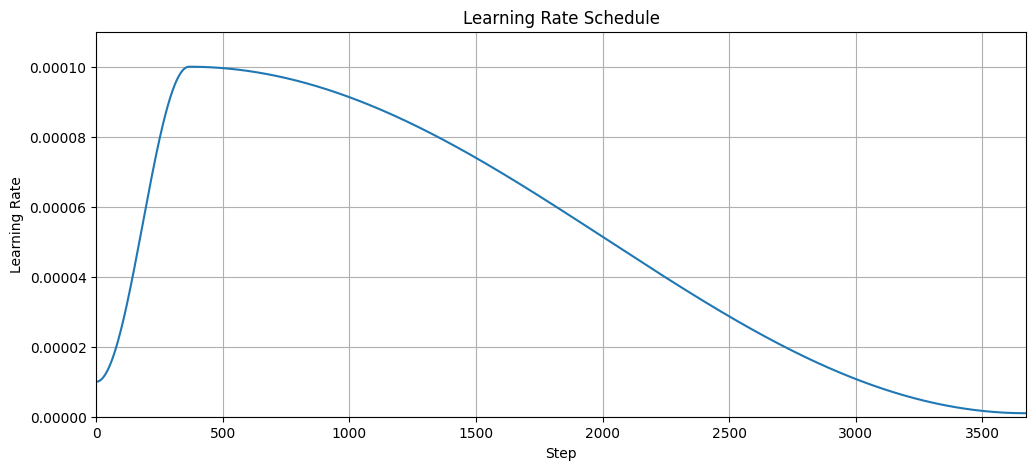

In [27]:
# Plot Learning Rate Scheduler
def plot_lr_scheduler():
    lr_scheduler = get_lr_scheduler(torch.optim.Adam(model.parameters()))
    lrs  = []
    for step in range(CONFIG.N_STEPS):
        lrs.append(lr_scheduler.get_last_lr())
        lr_scheduler.step()
    # Plot Learning Rate
    plt.figure(figsize=(12,5))
    plt.title('Learning Rate Schedule')
    plt.xlim(0, CONFIG.N_STEPS)
    plt.ylim(0, CONFIG.LR_MAX*1.1)
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.plot(lrs)
    plt.grid()
    plt.show()
    # Reset Learning Rate Scheduler
    lr_scheduler._step_count = 0
    lr_scheduler.last_epoch = 0

plot_lr_scheduler()

# Metrics

In [28]:
# Average meter to keep track of metrics/loss during training
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        # Average is simply the sum divided by the count
        self.avg = self.sum / self.count

In [29]:
# Average meter to keep track of metrics/loss during training
class R2_METRIC(object):
    def __init__(self):
        self.reset()
        self.y_mean = torch.tensor(train0[CONFIG.TARGET_COLUMNS].median(axis=0).values).to('cuda')

    def reset(self):
        self.avg = torch.zeros(CONFIG.N_TARGETS).to('cuda')
        self.rss = torch.zeros(CONFIG.N_TARGETS).to('cuda')
        self.tss = torch.zeros(CONFIG.N_TARGETS).to('cuda')

    def update(self, y_pred, y_true, mean=False):
        self.rss += torch.sum((y_true - y_pred)**2, dim=0)
        self.tss += torch.sum((y_true - self.y_mean)**2, dim=0)
        self.avg = 1 - (self.rss / torch.maximum(self.tss, CONFIG.EPS_CUDA))

# Loss

In [30]:
# Y_SHIFT As Torch Tensor On GPU
Y_SHIFT_CUDA = torch.tensor(Y_SHIFT).to('cuda')
Y_STD_CUDA = torch.tensor(Y_STD).to('cuda')
# Is Log Feature Flag
IS_LOG_FEATURE = torch.tensor(np.isin(CONFIG.TARGET_COLUMNS, LOG_FEATURES)).to('cuda')

def denormalize(y_pred, y_true=None):
    # Scale Back
    y_pred = (y_pred * Y_STD_CUDA) + Y_SHIFT_CUDA
#     # Log Scale
#     y_pred = torch.where(IS_LOG_FEATURE, 10**y_pred, y_pred)
    # Optionally Denormalize y_true
    if y_true is not None:
        y_true = (y_true * Y_STD_CUDA) + Y_SHIFT_CUDA
#         y_true = torch.where(IS_LOG_FEATURE, 10**y_true, y_true)
        return y_pred, y_true
    else:
        return y_pred

In [31]:
# Mean feature values used to compute R2 loss
Y_MEDIAN = torch.tensor(CONFIG.TARGET_MEDIANS).to('cuda')
# Total Variation
MEAN_VARIATION = torch.tensor(
        (CONFIG.TARGET_MEDIANS - y_train_mask_raw)
    ).abs().mean(dim=0).to('cuda')
# R2 Loss
def r2_loss_fn(y_pred, y_true):
    B = len(y_pred)
    # Compute column wise sum of residuals and totals
    ss_res = (y_true - y_pred)**2
    ss_total = (y_true - Y_MEDIAN)**2
    # r2 ranging from 0 to infinity
    loss = torch.sum(ss_res, dim=0) / torch.maximum(torch.sum(ss_total, dim=0), CONFIG.EPS_CUDA)
    # Return Mean Of Loss
    return torch.mean(loss)

r2_loss_fn(denormalize(outputs['label']), denormalize(y_batch.to('cuda')))

tensor(1.4101, device='cuda:0', dtype=torch.float64)

In [32]:
def validation_step(models, val_dl, weights=[1,1,1]):
    # Put model in evaluation mode
    for model in models:
        model.eval()
    # Loss Function
    R2_LOSS_FN = r2_loss_fn
    # Metrics Trackers
    R2 = R2_METRIC()
    R2_LOSS = AverageMeter()
    # Iterave Over Validation Set
    for step, (X_sample, y_true) in enumerate(val_dl):
        y_true = y_true.to('cuda')
        # Put label on GPU
        with torch.no_grad():
            for k, v in X_sample.items():
                X_sample[k] = v.to('cuda')
            # Forward Pass
#             models[2](X_sample)['label']
            y_preds = torch.stack([weights[i] * model(X_sample)['label'] for i, model in enumerate(models)]).to('cuda')
            # Compute weighted average of predictions
            y_pred = torch.sum(y_preds, dim=0) / sum(weights)
            
#             print(y_preds[:, :3, :], y_pred[:3, :])
        # Denormalize
        y_pred_raw, y_true_raw = denormalize(y_pred, y_true)
        # Loss
        r2_loss = R2_LOSS_FN(y_pred_raw, y_true_raw)
        # Update Loss Metrics
        R2_LOSS.update(r2_loss)
        # Update Metrics
        R2.update(y_pred_raw, y_true_raw)
        # Logs
        r2_str = ", ".join(
            [f"{f}: {v:+.3f}" for f, v in zip(CONFIG.TARGET_COLUMNS_TEST, R2.avg)
        ])
        if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_VAL_STEPS_PER_EPOCH:
            print(
                f'VAL | R2 loss: {R2_LOSS.avg:.4f}, R2: {R2.avg.mean():.3f}, {r2_str}' + (' ' * 10)
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'\rVAL {step+1:02d}/{CONFIG.N_VAL_STEPS_PER_EPOCH} | R2 loss: {R2_LOSS.avg:.4f}, ' +
                f'R2: {R2.avg.mean():.3f}, {r2_str}' + (' ' * 10),
                end='\n' if (step + 1) == CONFIG.N_VAL_STEPS_PER_EPOCH else '', flush=True,
            )
    
validation_step(models, val_dataloader, weights=[1,2,3])

VAL 87/87 | R2 loss: 0.9441, R2: 0.060, X4: -0.021, X11: -0.119, X18: +0.215, X50: +0.086, X26: +0.040, X3112: +0.159          


# Training

In [33]:
# Loss
R2_LOSS_FN = r2_loss_fn
# Optimizer

# Metrics Trackers
R2 = R2_METRIC()
R2_LOSS = AverageMeter()

In [34]:
# if CONFIG.TRAIN_MODEL:
for i, model in enumerate(models):
    print(f'Training model{i}: {model.name}')
    train_dl, val_dl = get_dataloaders(model.name)
    # Learning Rate Scheduler
    optimizer = optimizers[i]
    LR_SCHEDULER = get_lr_scheduler(optimizer)
    for epoch in range(CONFIG.N_EPOCHS):
        # Reset Metrics
        R2.reset()
        R2_LOSS.reset()
        # Put model in training mode
        model.train()
        # Iterate Over Training Dataloader
        for step, (X_batch, y_true) in enumerate(train_dl):
            # Put batch on GPU
            for k, v in X_batch.items():
                X_batch[k] = v.to('cuda')
            y_true = y_true.to('cuda')
            # Step Time
            t_start = time.perf_counter_ns()
            # Forward Pass
            y_pred = model(X_batch)['label']
            # Denormalize
            y_pred_raw, y_true_raw = denormalize(y_pred, y_true)
            # Loss
            r2_loss = R2_LOSS_FN(y_pred_raw, y_true_raw)
            # Update Loss Metrics
            R2_LOSS.update(r2_loss)
            # Compute Gradients
            r2_loss.backward()
            # Backward Pass
            optimizer.step()
            # Zero Out Gradients
            optimizer.zero_grad()
            # Update Metrics
            R2.update(y_pred_raw, y_true_raw)
            # Compute R2 Metrics String
            r2_str = ", ".join([
                f"{f}: {v:+.3f}" for f, v in zip(CONFIG.TARGET_COLUMNS_TEST, R2.avg)
            ])
            # Logs
            if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_EPOCH:
                print(
                    f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'R2 loss: {R2_LOSS.avg:.4f}, R2: {R2.avg.mean():+.3f}, {r2_str}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'\rEPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'R2 loss: {R2_LOSS.avg:.4f}, R2: {R2.avg.mean():+.3f}, {r2_str}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                    end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
                )
            # Learning Rate Scheduler Step
            LR_SCHEDULER.step()
        validation_step([model], val_dl, [1])
            
    
# Validation Step
validation_step(models, val_dl, [1,0.8,1])

# Save entire model object
for i, model in enumerate(models):
    torch.save(model, f'model-{model.name}.pth')

Training model0: efficientnetv2_rw_t.ra2_in1k
EPOCH 01 0459/459 | R2 loss: 0.8474, R2: +0.156, X4: +0.047, X11: +0.069, X18: +0.465, X50: +0.111, X26: +0.041, X3112: +0.203, step: 0.460s, lr: 9.98e-05
VAL 87/87 | R2 loss: 0.6694, R2: 0.286, X4: +0.234, X11: +0.175, X18: +0.614, X50: +0.241, X26: +0.125, X3112: +0.329          
EPOCH 02 0459/459 | R2 loss: 0.6426, R2: +0.297, X4: +0.255, X11: +0.188, X18: +0.642, X50: +0.236, X26: +0.154, X3112: +0.304, step: 0.459s, lr: 9.34e-05
VAL 87/87 | R2 loss: 0.6389, R2: 0.315, X4: +0.271, X11: +0.200, X18: +0.658, X50: +0.258, X26: +0.153, X3112: +0.347          
EPOCH 03 0459/459 | R2 loss: 0.6065, R2: +0.339, X4: +0.301, X11: +0.260, X18: +0.663, X50: +0.277, X26: +0.178, X3112: +0.355, step: 0.459s, lr: 7.89e-05
VAL 87/87 | R2 loss: 0.6247, R2: 0.330, X4: +0.289, X11: +0.218, X18: +0.670, X50: +0.271, X26: +0.172, X3112: +0.362          
EPOCH 04 0459/459 | R2 loss: 0.5613, R2: +0.368, X4: +0.348, X11: +0.283, X18: +0.696, X50: +0.268, X26: 

In [35]:
validation_step(models, val_dl, [1,0.8,1])


VAL 87/87 | R2 loss: 0.5916, R2: 0.357, X4: +0.326, X11: +0.254, X18: +0.702, X50: +0.295, X26: +0.176, X3112: +0.389          


In [36]:
validation_step(models, val_dl, [0.8,0.7,1])


VAL 87/87 | R2 loss: 0.5915, R2: 0.357, X4: +0.326, X11: +0.254, X18: +0.702, X50: +0.295, X26: +0.177, X3112: +0.389          


In [37]:
validation_step(models, val_dl, [0.7,0.3,1])


VAL 87/87 | R2 loss: 0.5917, R2: 0.358, X4: +0.325, X11: +0.254, X18: +0.704, X50: +0.294, X26: +0.178, X3112: +0.391          


In [ ]:
# # Minimum And Maximum Values To Clip Predictions
# TARGET_MIN = train0[CONFIG.TARGET_COLUMNS].values.min(axis=0)
# TARGET_MAX = train0[CONFIG.TARGET_COLUMNS].values.max(axis=0)
# # Submission Rows
# SUBMISSION_ROWS = []
# # Put Model in Evaluation Mode
# model.eval()
# for i, (X_sample_test, test_id) in enumerate(tqdm(test_dataset)):
#     # Only 100 predictions in interactive mode
#     if CONFIG.IS_INTERACTIVE and i == 100:
#         break
#     # Put sample on GPU and add batch dimension
#     for k, v in X_sample_test.items():
#         X_sample_test[k] = v.to('cuda').unsqueeze(0)
#     # Prediction without gradients
#     with torch.no_grad():
#         y_pred = model(X_sample_test)['label']
#     # Reverse Scaling
#     y_pred, _ = denormalize(y_pred, y_pred)
#     y_pred = y_pred.detach().cpu().numpy().squeeze()
#     # Clip Values
#     y_pred = np.clip(y_pred, TARGET_MIN, TARGET_MAX)
#     # Add To Rows
#     row = { 'id': test_id }
#     # Add Predictions column by column
#     for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
#         # Remove "_mean" part of target column
#         row[k.replace('_mean', '')] = v
#     # Add To Submission Rows
#     SUBMISSION_ROWS.append(row)

In [ ]:
# # Make Submission CSV
# submission_df = pd.DataFrame(SUBMISSION_ROWS)

# display(submission_df.head(30))

# # Make
# submission_df.to_csv('submission.csv', index=False)